In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#spark imports
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row, SparkSession
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator 

spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()

In [2]:
#import books data
books_df_file_location = "dataset\\cleaned_data_books_version_3.csv"
file_type = "csv"

# CSV options
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
books = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sto_readep", delimiter) \
  .load(books_df_file_location)

books.show()

# Create Temporary Tables
books.createOrReplaceTempView("books")

+---+--------+------------+-----------+-------------+--------------------+-------------------------+--------------------+--------------+-------------+------------------+-----------------------+--------------------+
| id| book_id|best_book_id|books_count|       isbn13|             authors|original_publication_year|      original_title|average_rating|ratings_count|work_ratings_count|work_text_reviews_count|           image_url|
+---+--------+------------+-----------+-------------+--------------------+-------------------------+--------------------+--------------+-------------+------------------+-----------------------+--------------------+
|  1| 2767052|     2767052|        272|9780439023480|     Suzanne Collins|                     2008|    The Hunger Games|          4.34|      4780653|         4942365.0|                 155254|https://images.gr...|
|  2|       3|           3|        491|9780439554930|J.K. Rowling, Mar...|                     1997|Harry Potter and ...|          4.44|    

In [3]:
#import to_read data
to_read_df_file_location = "dataset\\to_read.csv"
file_type = "csv"

# CSV options
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
to_read = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(to_read_df_file_location)

to_read.show()

# Create Temporary Tables
to_read.createOrReplaceTempView("to_read")

+-------+-------+
|user_id|book_id|
+-------+-------+
|      1|    112|
|      1|    235|
|      1|    533|
|      1|   1198|
|      1|   1874|
|      1|   2058|
|      1|   3334|
|      2|      4|
|      2|     11|
|      2|     13|
|      2|     16|
|      2|     92|
|      2|    106|
|      2|    113|
|      2|    233|
|      2|    247|
|      2|    380|
|      2|    408|
|      2|    439|
|      2|    479|
+-------+-------+
only showing top 20 rows



In [4]:
#import ratings data
ratings_df_file_location = "dataset\\ratings.csv"
file_type = "csv"

# CSV options
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
ratings = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(ratings_df_file_location)

ratings.show()

# Create Temporary Tables
ratings.createOrReplaceTempView("ratings")

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    314|     5|
|      1|    439|     3|
|      1|    588|     5|
|      1|   1169|     4|
|      1|   1185|     4|
|      1|   2077|     4|
|      1|   2487|     4|
|      1|   2900|     5|
|      1|   3662|     4|
|      1|   3922|     5|
|      1|   5379|     5|
|      1|   5461|     3|
|      1|   5885|     5|
|      1|   6630|     5|
|      1|   7563|     3|
|      1|   9246|     1|
|      1|  10140|     4|
|      1|  10146|     5|
|      1|  10246|     4|
|      1|  10335|     4|
+-------+-------+------+
only showing top 20 rows



Alle nodige data voor het model is ingeladen in Spark, maar om toch nog even te kijken naar bepaalde statistieken, importeer ik het ook naar een Pandas DataFrame.

In [5]:
books_df =  pd.read_csv("dataset\\cleaned_data_books_version_3.csv")
to_read_df = pd.read_csv("dataset\\to_read.csv")
ratings_df = pd.read_csv("dataset\\ratings.csv")

In [6]:
#Top books with most number of ratings on goodbooks

books_df.sort_values(by = 'ratings_count', ascending = False)[['original_title','ratings_count', 'average_rating' ]][0:10]

,original_title,ratings_count,average_rating
0,The Hunger Games,4780653,4.34
1,Harry Potter and the Philosopher's Stone,4602479,4.44
2,Twilight,3866839,3.57
3,To Kill a Mockingbird,3198671,4.25
4,The Great Gatsby,2683664,3.89
5,The Fault in Our Stars,2346404,4.26
6,The Hobbit or There and Back Again,2071616,4.25
7,The Catcher in the Rye,2044241,3.79
9,Pride and Prejudice,2035490,4.24
8,Angels & Demons,2001311,3.85


In [7]:
books_df.average_rating = books_df.average_rating.astype('float')

#Top books with top average ratings on goodbooks

books_df.sort_values(by = 'average_rating', ascending = False)[['original_title','ratings_count', 'average_rating' ]][0:10]

,original_title,ratings_count,average_rating
3362,The Complete Calvin and Hobbes,28900,4.82
825,Words of Radiance,73572,4.77
7887,Mark of the Lion Trilogy,9081,4.76
4128,It's a Magical World: A Calvin and Hobbes Coll...,22351,4.75
404,Complete Harry Potter Boxed Set,190050,4.74
5785,There's Treasure Everywhere: A Calvin and Hobb...,16766,4.74
3474,"Harry Potter Collection (Harry Potter, #1-6)",24618,4.73
5981,The Authoritative Calvin and Hobbes,16087,4.73
6272,The Indispensable Calvin and Hobbes: A Calvin ...,14597,4.73
8473,Attack of the Deranged Mutant Killer Monster S...,9713,4.72


In [8]:
#author with most written books
authors_with_most_books = pd.DataFrame(books_df.authors.value_counts()[0:10]).reset_index()
authors_with_most_books.columns = ['author', 'number_of_books']

authors_with_most_books

#damn, Nora Roberts has written more books than Stephen King, and I have never heard of her

,author,number_of_books
0,Nora Roberts,59
1,Stephen King,57
2,Dean Koontz,43
3,Terry Pratchett,41
4,Agatha Christie,38
5,Meg Cabot,37
6,James Patterson,36
7,J.D. Robb,33
8,David Baldacci,32
9,John Grisham,31


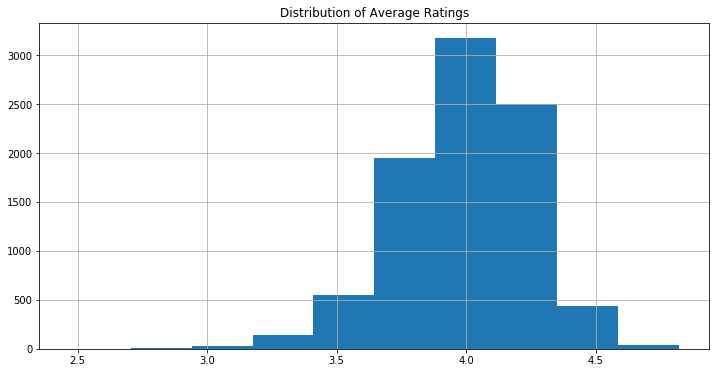

In [9]:
plt.figure(figsize=(12,6))
plt.title('Distribution of Average Ratings')
books_df['average_rating'].hist()
display()

In [10]:
ratings_df.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [11]:
ratings_df.describe()
#almost 1 million ratings

,book_id,user_id,rating
count,981756.000000,981756.000000,981756.000000
mean,4943.275636,25616.759933,3.856534
std,2873.207415,15228.338826,0.983941
min,1.000000,1.000000,1.000000
25%,2457.000000,12372.000000,3.000000
50%,4921.000000,25077.000000,4.000000
75%,7414.000000,38572.000000,5.000000
max,10000.000000,53424.000000,5.000000


In [12]:
#almost each book has 100 ratings in the ratingss dataframe

ratings_df.groupby('book_id').count()

,user_id,rating
book_id,,
1,100,100
2,100,100
3,100,100
4,100,100
5,100,100
...,...,...
9996,98,98
9997,89,89
9998,95,95


In [13]:
# Count the total number of ratings in the dataset
numerator = ratings.select("rating").count()

# Count the number of distinct Id's
num_users = ratings.select("user_id").distinct().count()
num_items = ratings.select("book_id").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of items
denominator = num_users * num_items

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator * 1.0)/ denominator) * 100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  99.82% empty.


Now, seeing as the dataframe is 99.82% empty, I can explain that. It simply cannot be possible for every unique user to have rated all the books in the dataframe.Therefore, it's better to build an algorithm only on the basis of the original ratings. Here's where ALS comes into play. But first, some extra information.

In [14]:
# Min num ratings 
print("Item with the fewest ratings: ")
ratings.groupBy("book_id").count().sort('count').show(10)

Item with the fewest ratings: 
+-------+-----+
|book_id|count|
+-------+-----+
|   7803|    8|
|   9345|   11|
|   9486|   24|
|   1935|   34|
|   9315|   36|
|   9553|   41|
|   8181|   44|
|   9260|   46|
|   9479|   47|
|   9705|   48|
+-------+-----+
only showing top 10 rows



In [15]:
# Group data by user_id, count ratings
(ratings.groupBy("user_id")
    .count()
    .filter("`count` >= 5")
    .orderBy('count', ascending=False)
    .show(n = 10))

+-------+-----+
|user_id|count|
+-------+-----+
|  12874|  200|
|  30944|  200|
|  12381|  199|
|  28158|  199|
|  52036|  199|
|   6630|  197|
|  37834|  197|
|  45554|  197|
|   9806|  196|
|  19729|  196|
+-------+-----+
only showing top 10 rows



In [16]:
(ratings.groupBy("book_id")
    .count()
    .filter("`count` > 1")
    .orderBy('count', ascending=False)
    .show(n = 10))

+-------+-----+
|book_id|count|
+-------+-----+
|     31|  100|
|    516|  100|
|   1139|  100|
|   1143|  100|
|   1270|  100|
|   1303|  100|
|   1322|  100|
|   1339|  100|
|   1352|  100|
|   1618|  100|
+-------+-----+
only showing top 10 rows



In [17]:
#now, we split the data into training and test sets to use for the ALS algorithm
(training,test)=ratings.randomSplit([0.8, 0.2])

In [18]:
test.show(5)

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    588|     5|
|      1|   2487|     4|
|      1|   5885|     5|
|      1|   9246|     1|
|      1|  10140|     4|
+-------+-------+------+
only showing top 5 rows



In [19]:
#here, ALS and a regression evaluator is imported so we can find RMSE
als=ALS(maxIter=5,regParam=0.09,rank=25,userCol="user_id",itemCol="book_id", ratingCol="rating",coldStartStrategy="drop",nonnegative=True, implicitPrefs = False)
model=als.fit(training)

In [20]:
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 75, 100]) \
            .addGrid(als.maxIter, [5, 50, 75, 100]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()

In [21]:
# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName = "rmse", 
                                labelCol = "rating", 
                                predictionCol = "prediction")
# Print length of evaluator
print ("Num models to be tested using param_grid: ", len(param_grid))

Num models to be tested using param_grid:  64


In [22]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator = als, 
                    estimatorParamMaps = param_grid, 
                    evaluator = evaluator, 
                    numFolds = 5)

In [23]:
model = als.fit(training)

In [24]:
predictions = model.transform(test)

In [25]:
predictions.show(n = 10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   3087|     3| 3.5726216|
|    148|  13034|     4| 3.4461586|
|    148|  13879|     3|  3.371085|
|    148|  10140|     3| 2.9592822|
|    148|  20967|     3| 3.8144488|
|    148|  26244|     4| 3.3857484|
|    148|   9125|     1| 2.0415683|
|    148|   2171|     4| 3.5932786|
|    148|  11272|     3| 3.2192776|
|    148|  51166|     4|  3.791177|
+-------+-------+------+----------+
only showing top 10 rows



In [26]:
predictions.createOrReplaceTempView("predictions")

In [27]:
# Generate n recommendations for all users
ALS_recommendations = model.recommendForAllUsers(numItems = 10) # n - 10

In [28]:
ALS_recommendations.show(n = 10)

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    148|[[7947, 5.0888543...|
|    463|[[8946, 5.634342]...|
|    471|[[8946, 3.2117507...|
|    496|[[7947, 6.0149026...|
|    833|[[9529, 5.678939]...|
|   1088|[[7947, 5.0328407...|
|   1238|[[9260, 4.2068143...|
|   1342|[[9076, 5.2430983...|
|   1580|[[7337, 5.30806],...|
|   1591|[[9973, 4.950328]...|
+-------+--------------------+
only showing top 10 rows



In [29]:
# Temporary table
ALS_recommendations.registerTempTable("ALS_recs_temp")

In [30]:
clean_recs = spark.sql("""SELECT user_id,
                            movieIds_and_ratings.book_id AS book_id,
                            movieIds_and_ratings.rating AS prediction
                        FROM ALS_recs_temp
                        LATERAL VIEW explode(recommendations) exploded_table
                            AS movieIds_and_ratings""")
clean_recs.show()

+-------+-------+----------+
|user_id|book_id|prediction|
+-------+-------+----------+
|    148|   7947| 5.0888543|
|    148|   8946|  5.068738|
|    148|   8013|  5.021634|
|    148|   8854| 4.9729347|
|    148|   8182| 4.8573627|
|    148|   7844| 4.8211856|
|    148|   9518| 4.7942834|
|    148|   9529| 4.7346225|
|    148|   1597|  4.713855|
|    148|   9209| 4.7105503|
|    463|   8946|  5.634342|
|    463|   1935| 5.1030245|
|    463|   5493| 5.0051136|
|    463|   9028|  4.945355|
|    463|   3104|  4.911579|
|    463|   9518| 4.8730435|
|    463|   6089|  4.825017|
|    463|   8831| 4.8189425|
|    463|   6312| 4.8025827|
|    463|   5258| 4.7892976|
+-------+-------+----------+
only showing top 20 rows



In [31]:
# Recommendations for unread books
(clean_recs.join(ratings, ["user_id", "book_id"], "left")
    .filter(ratings.rating.isNull()).show())

+-------+-------+----------+------+
|user_id|book_id|prediction|rating|
+-------+-------+----------+------+
|      4|   9842| 5.3846364|  null|
|     78|   6714| 2.4631793|  null|
|    101|   8831|  5.438351|  null|
|    102|   9842|  2.866275|  null|
|    107|   7844| 4.0796404|  null|
|    135|   8522| 4.3749366|  null|
|    141|   8028|  4.619835|  null|
|    145|   9051|  4.923432|  null|
|    190|   9518| 5.1266055|  null|
|    200|   7550|  4.083704|  null|
|    217|   8013| 4.9587927|  null|
|    277|   7881| 4.6523633|  null|
|    309|   7063| 4.6414742|  null|
|    329|   6149| 4.7050533|  null|
|    338|   2667|  4.977938|  null|
|    366|    126| 4.0352497|  null|
|    382|   8926| 3.4802144|  null|
|    387|   9529| 3.9604864|  null|
|    436|   5268| 4.9204936|  null|
|    441|   7844|  5.139341|  null|
+-------+-------+----------+------+
only showing top 20 rows



In [32]:
new_books = (clean_recs.join(ratings, ["user_id", "book_id"], "left")
    .filter(ratings.rating.isNull()))

In [33]:
new_books.show()

+-------+-------+----------+------+
|user_id|book_id|prediction|rating|
+-------+-------+----------+------+
|      4|   9842| 5.3846364|  null|
|     78|   6714| 2.4631793|  null|
|    101|   8831|  5.438351|  null|
|    102|   9842|  2.866275|  null|
|    107|   7844| 4.0796404|  null|
|    135|   8522| 4.3749366|  null|
|    141|   8028|  4.619835|  null|
|    145|   9051|  4.923432|  null|
|    190|   9518| 5.1266055|  null|
|    200|   7550|  4.083704|  null|
|    217|   8013| 4.9587927|  null|
|    277|   7881| 4.6523633|  null|
|    309|   7063| 4.6414742|  null|
|    329|   6149| 4.7050533|  null|
|    338|   2667|  4.977938|  null|
|    366|    126| 4.0352497|  null|
|    382|   8926| 3.4802144|  null|
|    387|   9529| 3.9604864|  null|
|    436|   5268| 4.9204936|  null|
|    441|   7844|  5.139341|  null|
+-------+-------+----------+------+
only showing top 20 rows



In [34]:
to_read.show(5)

+-------+-------+
|user_id|book_id|
+-------+-------+
|      1|    112|
|      1|    235|
|      1|    533|
|      1|   1198|
|      1|   1874|
+-------+-------+
only showing top 5 rows



In [35]:
# Create Temporary Tables
new_books.createOrReplaceTempView("new_books")
to_read.createOrReplaceTempView("to_read")

In [36]:
recommendations = new_books.join(to_read,
                              on = ["user_id", "book_id"], 
                              how = "inner")
print(recommendations.show())

+-------+-------+----------+------+
|user_id|book_id|prediction|rating|
+-------+-------+----------+------+
|   9996|   7881|  4.440891|  null|
|  38566|   8522|  4.588436|  null|
|   7614|   8362| 3.8273478|  null|
|  45266|   5413| 4.6749935|  null|
|   2662|    100|  4.291405|  null|
|  11496|   8680| 2.8196623|  null|
|  38387|    589|  3.888134|  null|
|  45289|   7337| 4.0168257|  null|
|  53303|   3885| 3.8883677|  null|
|    888|   4643| 3.4073799|  null|
|  13300|   5212| 5.0100913|  null|
|  22985|   4346| 4.1970944|  null|
|  44039|   2263|   3.92553|  null|
|  47342|   3124|  4.686724|  null|
|  20176|   5275|  4.602424|  null|
|  26924|    673|  5.018472|  null|
|  38552|   4287| 4.3390274|  null|
|  10037|   8013|  4.993116|  null|
|  44628|   1471| 3.6191816|  null|
|  50752|   7740| 4.7946463|  null|
+-------+-------+----------+------+
only showing top 20 rows

None


In [37]:
# Create Temporary Tables
recommendations.createOrReplaceTempView("recommendations")

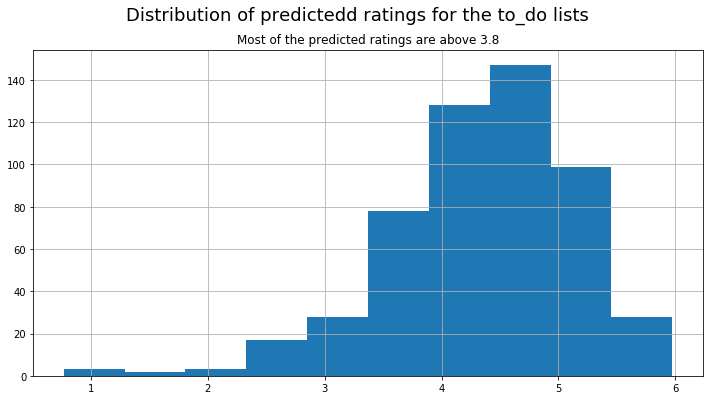

In [38]:
plt.figure(figsize=(12,6))
plt.title('Most of the predicted ratings are above 3.8', fontsize = 12)
plt.suptitle('Distribution of predictedd ratings for the to_do lists', fontsize = 18)
rec = recommendations.toPandas()
rec['prediction'].hist()
display()